<h1> APS - Mineração de Dados S73</h1>
<h2> Sports Analytics - NFL </h2>
<h3> By: Luan Carlos Klein </h3>

<h2> Importando as bibliotecas </h2>

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import math
from sklearn.linear_model import LinearRegression

from sklearn.covariance import EllipticEnvelope

import warnings
warnings.filterwarnings('ignore')

In [2]:
path_basic_data = os.path.join("data", "Basic_Stats.csv")
path_game_stats_quarterback = os.path.join("data", "Game_Logs_Quarterback.csv")

In [3]:
df_basic = pd.read_csv(path_basic_data)
df_game_stats_qb = pd.read_csv(path_game_stats_quarterback)

<h2> Pré-Processamento </h2>

In [4]:
df_game_stats_qb = df_game_stats_qb.replace(["--"],0) ## Troca os -- por 0
df_game_stats_qb = df_game_stats_qb.fillna(0) ## Preenche com 0 os valores nulos

In [5]:
## Transforma as colunas para o tipo float
columns_float_qb = ['Games Played',
       'Games Started', 'Passes Completed', 'Passes Attempted',
       'Completion Percentage', 'Passing Yards', 'Passing Yards Per Attempt',
       'TD Passes', 'Ints', 'Sacks', 'Sacked Yards Lost', 'Passer Rating',
       'Rushing Attempts', 'Rushing Yards', 'Yards Per Carry', 'Rushing TDs',
       'Fumbles', 'Fumbles Lost']

for i in columns_float_qb:
    df_game_stats_qb[i] = df_game_stats_qb[i].astype(float)

In [6]:
## Define quais serão as features a serem pontuadas
info_important_qb = ['TD Passes_avg', 'Passing Yards_avg', 'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg']

<b>Pontuação dos jogadores</b>
<br>1 ponto   ---> 25 jardas passadas
<br>1 ponto   ---> 10 jardas corridas ou recebidas
<br>4 pontos  ---> Tocuhdown passado
<br>6 pontos  ---> Touchdown corrido ou recebido
<br>-2 pontos ---> Interceptação ou fumble
<br><i>Kickers</i>
<br>1 ponto   ---> Extra point
<br>3 pontos  ---> Field Goal até 49 jardas
<br>5 pontos  ---> Field Goal de mais de 50 jardas
<br><i>Defesas </i>
<br>1 ponto   ---> Sack
<br>2 pontos  ---> Interceptação ou fumble
<br>2 pontos  ---> Safety
<br>6 pontos  ---> Touchdown defensivo ou do Special Team
<br>10 pontos ---> Não sofrer pontos
<br>7 pontos  ---> Sofrer até 6 pontos
<br>4 pontos  ---> Sofrer 7-13 pontos
<br>1 ponto   ---> Sofrer 14-20 pontos
<br>0 ponto   ---> Sofrer 21-27 pontos
<br>-1 ponto  ---> Sofrer 28-34 pontos
<br>-4 pontos ---> Sofrer mais de 35 pontos
<br>
<br> Fonte <i> https://www.golimsports.com.br/post/fantasy-football-o-que-%C3%A9-e-como-funciona#:~:text=O%20restante%20das%20pontua%C3%A7%C3%B5es%20%C3%A9,Fumble%20perdido%20que%20ele%20sofreu. </i>

<h3> Função Geral para a Predição de Um Atleta</h3>

In [7]:
## Variáveis para analisar após o processamento
df_colleges = None
df_age = None
df_birthdayplace = None
df_outliers = None

def generate_predict(player_name):
    global df_colleges
    global df_age
    global df_birthdayplace
    global df_outliers
    try:
        ###############################################################
        ### Definição das funções
        
        ## Função que calcula a pontuação para os QBs
        def calc_points_qb(df_in):
            df = df_in.copy()
            ## Calcula a pontuação
            dict_points_qb = {
                'TD Passes' : 4,
                'Passing Yards' : 1/25,
                'Fumbles' : -2,
                'Ints' : -2,
                'Rushing TDs' : 6
            }
            df = df.groupby(by=['Player Id', 'Year'], dropna=False).sum()
            df = df.reset_index()
            df['total_points'] = 0
            columns_use = []
            for i in dict_points_qb.keys():
                df[i] = df[i]*dict_points_qb[i]
                column_name = i+'_avg'
                columns_use.append(column_name)
                df[column_name] = df[i] / df['Games Played']
                df['total_points'] = df['total_points'] + df[i]
            columns_use.append('total_points_avg')
            df['total_points_avg'] = df['total_points'] / df['Games Played']
            return df
        
        ## Função que prepara os dados para a predição
        def prepare_data_predict(df, features, months):
            df_use = df.copy()
            df_use['Next Year'] = df_use['Year'] + 1 ## Define o ano para que aqueles dados serão a previsão
            useful_col = features.copy()
            useful_col.append('Player Id')
            useful_col.append('Next Year')
            for i in features:
                column_name = "avg_" + str(months) + "years_" + i
                df_use[column_name] = df_use[i].rolling(months).mean() ## Cálcula a média móvel
                df_use[column_name] = df_use[column_name].shift(periods=1) ## Desce os dados para o próximo ano
                useful_col.append(column_name)
            df_use['total_points_avg'] = df_use['total_points_avg'].shift(periods=1) ## Desce os dados para o próximo ano
            return df_use[useful_col]
        ###############################################################
        ## Filtra apenas para o jogador em questão
        df = df_game_stats_qb[df_game_stats_qb["Name"] == player_name]
        ## Calcula os pontos dele
        df = calc_points_qb(df)

        ############################################################
        ### ANÁLISE DE OUTLIER
        df_outliers = df[info_important_qb]
        df_info = df[["Player Id", "Year"]]
        outliers_list = EllipticEnvelope(random_state=10, contamination=0.1).fit_predict(df_outliers)
        df_outliers = df_outliers.assign(outlier = outliers_list)
        df_out = df_info.join(df_outliers)
        print(f"ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA {player_name}")
        print(df_out[df_out["outlier"] == -1])
        df_outliers = df_out[df_out["outlier"] == -1]
        ## Excluindo os outliers para a previsão
        df = df_out[df_out["outlier"] == 1]
        df = df.drop(columns=["outlier"])
        ###########################################################

        ##########################################################
        ### Definir os valores referentes a cada jogador
        df_basic_use = df_basic[df_basic["Name"] == player_name]
        year_birthday = int(pd.to_datetime(df_basic_use['Birthday']).dt.year) ## Ano de aniversário
        college = str(df_basic_use['College'].values[0])
        birth_place = str(df_basic_use['Birth Place'].values[0]) 
        #experience = str(df_basic_use['Experience'].values[0]) 
        #r = re.compile(r'\D')
        #experience = int(r.sub('', experience))
        ##########################################################

        ##########################################################
        ### Definir os valores referentes a universidade do jogador
        df_college = df_basic[df_basic["College"] == college]
        players_college = list(df_college['Player Id'])
        df_player_college_stats = df_game_stats_qb[df_game_stats_qb["Player Id"].isin(players_college) ]
        df_points_college = calc_points_qb(df_player_college_stats)
        col_use = info_important_qb.copy()
        col_use.append("Year") 
        df_points_college = df_points_college[col_use]
        df_avg_college = df_points_college.groupby(by=['Year'], dropna=False).mean()
        df_avg_college = df_avg_college.reset_index()
        ##########################################################

        ##########################################################
        ### Dados referentes a idade dos jogadores
        df_bithday = df_basic[['Player Id', 'Birthday']]
        df_bithday['Birthday'] = pd.to_datetime(df_bithday['Birthday']).dt.year
        df_points_all = calc_points_qb(df_game_stats_qb)
        col_use = info_important_qb.copy()
        col_use.append("Year")
        col_use.append("Player Id")
        df_points_all = df_points_all[col_use]
        df_points_age = df_points_all.merge(df_bithday, left_on='Player Id', right_on='Player Id')
        df_points_age = df_points_age.dropna()
        df_points_age['Age'] = df_points_age['Year'] - df_points_age['Birthday']
        df_points_age = df_points_age.drop(columns=['Year', 'Player Id', 'Birthday'])
        df_points_age = df_points_age.groupby(by=['Age'], dropna=False).mean()
        df_points_age = df_points_age.reset_index()
        df_age = df_points_age
        ##########################################################

        ##########################################################
        ### Dados referentes ao local de nascimento
        df_bithday_place = df_basic[['Player Id', 'Birth Place']]
        df_bithday_place['Birth Place'] = df_bithday_place['Birth Place'].apply(lambda x: str(x).split(', ')[-1])
        df_points_all = calc_points_qb(df_game_stats_qb)
        col_use = info_important_qb.copy()
        col_use.append("Player Id")
        df_points_all = df_points_all[col_use]
        df_points_bithday_place = df_points_all.merge(df_bithday_place, left_on='Player Id', right_on='Player Id')
        df_points_bithday_place = df_points_bithday_place.dropna()
        
        #Contar apenas aqueles lugares que tem pelo menos 50 atletas
        df_points_bithday_place_count = df_points_bithday_place.copy()
        df_points_bithday_place_count['qtd_players'] = 1
        df_points_bithday_place_count = df_points_bithday_place_count.groupby(['Birth Place']).count()
        df_points_bithday_place_count = df_points_bithday_place_count.reset_index()
        df_points_bithday_place_count = df_points_bithday_place_count[df_points_bithday_place_count["qtd_players"] >= 50]
        df_points_bithday_place_count = df_points_bithday_place_count[['Birth Place', 'qtd_players']]
        df_points_bithday_place = df_points_bithday_place.merge(df_points_bithday_place_count, left_on='Birth Place', right_on='Birth Place')
        df_points_bithday_place = df_points_bithday_place.groupby(by=['Birth Place'], dropna=False).mean()
        df_points_bithday_place = df_points_bithday_place.reset_index()
        df_points_bithday_place = df_points_bithday_place.sort_values(by='total_points_avg')
        df_birthdayplace = df_points_bithday_place
        ##########################################################

        ##########################################################
        ### Mudança no nome das colunas para usar depois
        cols = ['TD Passes_avg', 'Passing Yards_avg', 'Fumbles_avg', 'Ints_avg',
               'Rushing TDs_avg', 'total_points_avg']
        col_age = df_points_age.columns
        for i in col_age:
            df_points_age = df_points_age.rename({i: i+"_age"}, axis=1)

        col_age = df_avg_college.columns
        for i in col_age:
            df_avg_college = df_avg_college.rename({i: i+"_college"}, axis=1)
        ##########################################################

        ##########################################################
        ### Geração da Previsão para os próximos dois anos dele
        df_use = prepare_data_predict(df, cols, 3)
        print(df.columns)
        df_use = df_use.dropna()
        df_use['Age'] = df_use['Next Year'] - year_birthday - 1
        df_use = df_use.merge(df_points_age, left_on='Age', right_on='Age_age')
        df_use = df_use.merge(df_avg_college, left_on='Next Year', right_on='Year_college')

        df_train = df_use.head(len(df_use.index) - 2)
        df_test = df_use.tail(2)
        X = df_train.drop(columns = ['Player Id', 'Next Year', 'total_points_avg', 'Age', 'Age_age', 'Year_college'])
        y = df_train['total_points_avg']
        X_test = df_test.drop(columns = ['Player Id', 'Next Year', 'total_points_avg', 'Age', 'Age_age', 'Year_college'])
        y_test = df_test['total_points_avg']

        linear_regression = LinearRegression()
        linear_regression.fit(X,y)

        result_regression = linear_regression.predict(X_test)

        y_test = list(y_test)
        print("Previsto: ")
        print(result_regression)
        print("Real: ")
        print(y_test)
        print("#############################")
        print("Coeficientes da regressão:")
        print(linear_regression.feature_names_in_)
        print(linear_regression.coef_)
        
        errors_predict[player_name] = math.sqrt((result_regression[0]-y_test[0])**2 + (result_regression[1]-y_test[1])**2)/2
    except Exception as e:
        return e

<h2> Realizando a predição para todos os jogadores </h2>

In [8]:
players = list(df_basic['Name'])

errors_predict = {}
for i in players:
    generate_predict(i)

ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Demory, Bill
Empty DataFrame
Columns: [Player Id, Year, TD Passes_avg, Passing Yards_avg, Fumbles_avg, Ints_avg, Rushing TDs_avg, total_points_avg, outlier]
Index: []
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Savage, Tom
           Player Id  Year  TD Passes_avg  Passing Yards_avg  Fumbles_avg  \
2  tomsavage/2543640  2016       2.285714           5.131429    -0.571429   

   Ints_avg  Rushing TDs_avg  total_points_avg  outlier  
2      -0.0              0.0          6.845714       -1  
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Maddox, Tommy
             Player Id  Year  TD Passes_avg  Passing Yards_avg  F

ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Bartkowski, Steve
                 Player Id  Year  TD Passes_avg  Passing Yards_avg  \
2  stevebartkowski/2509103  1977            2.5             3.9800   
6  stevebartkowski/2509103  1981            7.5             9.5725   

   Fumbles_avg  Ints_avg  Rushing TDs_avg  total_points_avg  outlier  
2         -0.0    -3.250              0.0            3.2300       -1  
6         -0.0    -2.875              0.0           14.1975       -1  
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
Previsto: 
[16.06621128 18.9906524 ]
Real: 
[15.04857142857143, 10.02909090909091]
#############################
Coeficientes da regressão:
['TD Passes_avg' 'Passing Yards_avg' 'Fumbles_avg' 'Ints_avg'
 'Rushing TDs_avg' 'avg_3years_TD Passes_avg'
 'avg_3years_Passing Yards_avg' 'avg_3years_Fumbles_avg'
 'avg_3years_Ints_avg' 'avg_3years_Rushing

ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Jackson, Tarvaris
                 Player Id  Year  TD Passes_avg  Passing Yards_avg  \
2  tarvarisjackson/2495863  2008       3.666667           4.733333   

   Fumbles_avg  Ints_avg  Rushing TDs_avg  total_points_avg  outlier  
2         -1.0      -0.5              0.0               6.9       -1  
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
Previsto: 
[5.83963879 7.75644157]
Real: 
[-1.98, 5.29]
#############################
Coeficientes da regressão:
['TD Passes_avg' 'Passing Yards_avg' 'Fumbles_avg' 'Ints_avg'
 'Rushing TDs_avg' 'avg_3years_TD Passes_avg'
 'avg_3years_Passing Yards_avg' 'avg_3years_Fumbles_avg'
 'avg_3years_Ints_avg' 'avg_3years_Rushing TDs_avg'
 'avg_3years_total_points_avg' 'TD Passes_avg_age' 'Passing Yards_avg_age'
 'Fumbles_avg_age' 'Ints_avg_age' 'Rushing TDs_avg_age'
 'total_points_avg_age' 'TD

Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Kaepernick, Colin
                 Player Id  Year  TD Passes_avg  Passing Yards_avg  \
3  colinkaepernick/2495186  2014            4.0           7.334737   

   Fumbles_avg  Ints_avg  Rushing TDs_avg  total_points_avg  outlier  
3    -0.947368 -1.052632         0.315789          9.650526       -1  
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Mariota, Marcus
               Player Id  Year  TD Passes_avg  Passing Yards_avg  Fumbles_avg  \
0  marcusmariota/2552466  2015            5.0               7.86       -1.375   

   Ints_avg  Rushing TDs_avg  total_points_avg  outlier  
0    -1.375             0.75            

Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Leftwich, Byron
               Player Id  Year  TD Passes_avg  Passing Yards_avg  Fumbles_avg  \
4  byronleftwich/2505673  2007       1.333333           3.366667         -2.0   

   Ints_avg  Rushing TDs_avg  total_points_avg  outlier  
4 -0.666667              0.0          2.033333       -1  
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
Previsto: 
[2.35932513 6.78200811]
Real: 
[6.786666666666666, 2.584]
#############################
Coeficientes da regressão:
['TD Passes_avg' 'Passing Yards_avg' 'Fumbles_avg' 'Ints_avg'
 'Rushing TDs_avg' 'avg_3years_TD Passes_avg'
 'avg_3years_Passing Yards_avg' 'avg_3years_Fumbles_avg'
 'avg_3years_Ints_avg' 'avg_3years_Rushin

ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Orton, Kyle
           Player Id  Year  TD Passes_avg  Passing Yards_avg  Fumbles_avg  \
3  kyleorton/2506444  2008       4.210526           6.882105    -0.842105   

   Ints_avg  Rushing TDs_avg  total_points_avg  outlier  
3 -1.368421         0.947368          9.829474       -1  
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
Previsto: 
[12.25758152 16.85312123]
Real: 
[3.08, 3.7800000000000002]
#############################
Coeficientes da regressão:
['TD Passes_avg' 'Passing Yards_avg' 'Fumbles_avg' 'Ints_avg'
 'Rushing TDs_avg' 'avg_3years_TD Passes_avg'
 'avg_3years_Passing Yards_avg' 'avg_3years_Fumbles_avg'
 'avg_3years_Ints_avg' 'avg_3years_Rushing TDs_avg'
 'avg_3years_total_points_avg' 'TD Passes_avg_age' 'Passing Yards_avg_age'
 'Fumbles_avg_age' 'Ints_avg_age' 'Rushing TDs_avg_age'
 'total_points_avg_age' 'TD Pa

ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA May, Dean
Empty DataFrame
Columns: [Player Id, Year, TD Passes_avg, Passing Yards_avg, Fumbles_avg, Ints_avg, Rushing TDs_avg, total_points_avg, outlier]
Index: []
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Thompson, Kevin
Empty DataFrame
Columns: [Player Id, Year, TD Passes_avg, Passing Yards_avg, Fumbles_avg, Ints_avg, Rushing TDs_avg, total_points_avg, outlier]
Index: []
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Dilfer, Trent
             Player Id  Year  TD Passes_avg  Passing Yards_avg  Fumbles_avg  \
4  trentdilfer/2500392  1998           5.25             6.8225       -1.125   
9  trentdilfer/2500392 

ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Seurer, Frank
Empty DataFrame
Columns: [Player Id, Year, TD Passes_avg, Passing Yards_avg, Fumbles_avg, Ints_avg, Rushing TDs_avg, total_points_avg, outlier]
Index: []
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Tagge, Jerry
Empty DataFrame
Columns: [Player Id, Year, TD Passes_avg, Passing Yards_avg, Fumbles_avg, Ints_avg, Rushing TDs_avg, total_points_avg, outlier]
Index: []
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Rhome, Jerry
Empty DataFrame
Columns: [Player Id, Year, TD Passes_avg, Passing Yards_avg, Fumbles_avg, Ints_avg, Rushing TDs_avg, total_points_avg, outlier]
Index: []
Index(['Player Id', 'Year',

Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
Previsto: 
[7.71845085 9.17524036]
Real: 
[8.416666666666666, 10.372]
#############################
Coeficientes da regressão:
['TD Passes_avg' 'Passing Yards_avg' 'Fumbles_avg' 'Ints_avg'
 'Rushing TDs_avg' 'avg_3years_TD Passes_avg'
 'avg_3years_Passing Yards_avg' 'avg_3years_Fumbles_avg'
 'avg_3years_Ints_avg' 'avg_3years_Rushing TDs_avg'
 'avg_3years_total_points_avg' 'TD Passes_avg_age' 'Passing Yards_avg_age'
 'Fumbles_avg_age' 'Ints_avg_age' 'Rushing TDs_avg_age'
 'total_points_avg_age' 'TD Passes_avg_college'
 'Passing Yards_avg_college' 'Fumbles_avg_college' 'Ints_avg_college'
 'Rushing TDs_avg_college' 'total_points_avg_college']
[ 0.73390371  0.0333148  -0.18259519 -0.75171552 -0.38116923 -0.27535989
  0.67242507 -0.02879318  0.51828681  0.03022774  0.66071961 -0.06762279
 -0.25833442 -0.05353281  0.03770578  0.0054

Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
Previsto: 
[12.11601199  7.77750877]
Real: 
[13.55578947368421, 14.724]
#############################
Coeficientes da regressão:
['TD Passes_avg' 'Passing Yards_avg' 'Fumbles_avg' 'Ints_avg'
 'Rushing TDs_avg' 'avg_3years_TD Passes_avg'
 'avg_3years_Passing Yards_avg' 'avg_3years_Fumbles_avg'
 'avg_3years_Ints_avg' 'avg_3years_Rushing TDs_avg'
 'avg_3years_total_points_avg' 'TD Passes_avg_age' 'Passing Yards_avg_age'
 'Fumbles_avg_age' 'Ints_avg_age' 'Rushing TDs_avg_age'
 'total_points_avg_age' 'TD Passes_avg_college'
 'Passing Yards_avg_college' 'Fumbles_avg_college' 'Ints_avg_college'
 'Rushing TDs_avg_college' 'total_points_avg_college']
[ 1.57840865e-01 -4.32779162e-01  7.29239868e-03 -4.85793578e-02
 -5.85589893e-02  7.94044297e-02 -1.84760844e-01 -2.12253976e-02
 -6.04226226e-02  2.69599463e-04 -3.31299041e-01  2.917117

Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Hart, Jim
          Player Id  Year  TD Passes_avg  Passing Yards_avg  Fumbles_avg  \
5   jimhart/2516025  1975           5.25              7.245         -0.0   
13  jimhart/2516025  1983           3.20              4.736         -0.0   

    Ints_avg  Rushing TDs_avg  total_points_avg  outlier  
5     -2.875            0.375             9.995       -1  
13    -3.200            0.000             4.736       -1  
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
Previsto: 
[10.30497556 22.55882695]
Real: 
[9.456, 8.376000000000001]
#############################
Coeficientes da regressão:
['TD Passes_avg' 'Passing Yards_avg' 'Fumbles_avg' 'Ints_avg'
 'Rushing TDs_avg' 'a

Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Young, Vince
            Player Id  Year  TD Passes_avg  Passing Yards_avg  Fumbles_avg  \
0  vinceyoung/2506875  2006            2.6              5.254         -1.7   

   Ints_avg  Rushing TDs_avg  total_points_avg  outlier  
0      -1.5              2.4             7.054       -1  
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
Previsto: 
[6.64470473 8.16857706]
Real: 
[4.5840000000000005, 1.6800000000000004]
#############################
Coeficientes da regressão:
['TD Passes_avg' 'Passing Yards_avg' 'Fumbles_avg' 'Ints_avg'
 'Rushing TDs_avg' 'avg_3years_TD Passes_avg'
 'avg_3years_Passing Yards_avg' 'avg_3years_Fumbles_avg'
 'avg_3years_Ints_avg' 'avg_3years_R

Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
Previsto: 
[11.75441728 14.26521129]
Real: 
[11.88190476190476, 12.662857142857144]
#############################
Coeficientes da regressão:
['TD Passes_avg' 'Passing Yards_avg' 'Fumbles_avg' 'Ints_avg'
 'Rushing TDs_avg' 'avg_3years_TD Passes_avg'
 'avg_3years_Passing Yards_avg' 'avg_3years_Fumbles_avg'
 'avg_3years_Ints_avg' 'avg_3years_Rushing TDs_avg'
 'avg_3years_total_points_avg' 'TD Passes_avg_age' 'Passing Yards_avg_age'
 'Fumbles_avg_age' 'Ints_avg_age' 'Rushing TDs_avg_age'
 'total_points_avg_age' 'TD Passes_avg_college'
 'Passing Yards_avg_college' 'Fumbles_avg_college' 'Ints_avg_college'
 'Rushing TDs_avg_college' 'total_points_avg_college']
[-0.00193719  0.10999607  0.07870127 -0.14197064 -0.11108176  0.25471138
 -0.23604242  0.08157875  0.08533939 -0.0093157   0.9958689   0.2148685
  0.09872801 -0.00889785 -0.140

Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
Previsto: 
[5.47559236 5.04085269]
Real: 
[0.5666666666666668, 3.6733333333333333]
#############################
Coeficientes da regressão:
['TD Passes_avg' 'Passing Yards_avg' 'Fumbles_avg' 'Ints_avg'
 'Rushing TDs_avg' 'avg_3years_TD Passes_avg'
 'avg_3years_Passing Yards_avg' 'avg_3years_Fumbles_avg'
 'avg_3years_Ints_avg' 'avg_3years_Rushing TDs_avg'
 'avg_3years_total_points_avg' 'TD Passes_avg_age' 'Passing Yards_avg_age'
 'Fumbles_avg_age' 'Ints_avg_age' 'Rushing TDs_avg_age'
 'total_points_avg_age' 'TD Passes_avg_college'
 'Passing Yards_avg_college' 'Fumbles_avg_college' 'Ints_avg_college'
 'Rushing TDs_avg_college' 'total_points_avg_college']
[-0.10103198  0.09417504 -0.04397078 -0.06560577 -0.00952696 -0.06557926
 -0.12014985  0.02410112  0.06350311  0.         -0.03007745  0.18123302
  0.17592481  0.00517853 -0.004

ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Beck, John
          Player Id  Year  TD Passes_avg  Passing Yards_avg  Fumbles_avg  \
5  johnbeck/2507171  2012            2.0                3.9         -0.0   

   Ints_avg  Rushing TDs_avg  total_points_avg  outlier  
5      -0.0              0.0               5.9       -1  
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Siemian, Trevor
Empty DataFrame
Columns: [Player Id, Year, TD Passes_avg, Passing Yards_avg, Fumbles_avg, Ints_avg, Rushing TDs_avg, total_points_avg, outlier]
Index: []
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Tebow, Tim
         Player Id  Year  TD Passes_avg  Passing Yards_avg  Fumbles_

Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
Previsto: 
[-2.42563465  4.87128847]
Real: 
[8.92, -0.21428571428571427]
#############################
Coeficientes da regressão:
['TD Passes_avg' 'Passing Yards_avg' 'Fumbles_avg' 'Ints_avg'
 'Rushing TDs_avg' 'avg_3years_TD Passes_avg'
 'avg_3years_Passing Yards_avg' 'avg_3years_Fumbles_avg'
 'avg_3years_Ints_avg' 'avg_3years_Rushing TDs_avg'
 'avg_3years_total_points_avg' 'TD Passes_avg_age' 'Passing Yards_avg_age'
 'Fumbles_avg_age' 'Ints_avg_age' 'Rushing TDs_avg_age'
 'total_points_avg_age' 'TD Passes_avg_college'
 'Passing Yards_avg_college' 'Fumbles_avg_college' 'Ints_avg_college'
 'Rushing TDs_avg_college' 'total_points_avg_college']
[ 0.97808992  1.18301973 -0.02315798 -0.17007856  0.05096194  0.06740936
  0.34352139 -0.09520254 -0.00598411  0.082965    0.39270909  0.07380553
  0.11088079  0.00245809  0.03514877 -0.0

ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Harrington, Joey
                Player Id  Year  TD Passes_avg  Passing Yards_avg  \
6  joeyharrington/2505011  2008            0.0           1.306667   

   Fumbles_avg  Ints_avg  Rushing TDs_avg  total_points_avg  outlier  
6         -0.0 -0.666667              2.0              2.64       -1  
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
Previsto: 
[10.56097952 10.81770096]
Real: 
[7.674666666666667, 7.861333333333334]
#############################
Coeficientes da regressão:
['TD Passes_avg' 'Passing Yards_avg' 'Fumbles_avg' 'Ints_avg'
 'Rushing TDs_avg' 'avg_3years_TD Passes_avg'
 'avg_3years_Passing Yards_avg' 'avg_3years_Fumbles_avg'
 'avg_3years_Ints_avg' 'avg_3years_Rushing TDs_avg'
 'avg_3years_total_points_avg' 'TD Passes_avg_age' 'Passing Yards_avg_age'
 'Fumbles_avg_age' 'Ints_avg_age' 'Rushing TDs_avg_age'
 't

Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Luck, Andrew
            Player Id  Year  TD Passes_avg  Passing Yards_avg  Fumbles_avg  \
1  andrewluck/2533031  2013       6.181818           9.087273    -0.636364   

   Ints_avg  Rushing TDs_avg  total_points_avg  outlier  
1 -1.636364         1.090909         14.087273       -1  
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Lee, Bob
        Player Id  Year  TD Passes_avg  Passing Yards_avg  Fumbles_avg  \
0  boblee/2519294  1970       3.333333           4.066667         -0.0   

   Ints_avg  Rushing TDs_avg  total_points_avg  outlier  
0 -1.666667              1.0          6.733333       -1  
ANALISANDO UMA TEM

ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Carlson, Jeff
             Player Id  Year  TD Passes_avg  Passing Yards_avg  Fumbles_avg  \
2  jeffcarlson/2499990  1992       1.333333           3.093333    -1.333333   

   Ints_avg  Rushing TDs_avg  total_points_avg  outlier  
2      -2.0              0.0          1.093333       -1  
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Bartel, Richard
Empty DataFrame
Columns: [Player Id, Year, TD Passes_avg, Passing Yards_avg, Fumbles_avg, Ints_avg, Rushing TDs_avg, total_points_avg, outlier]
Index: []
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Everett, Jim
            Player Id  Year  TD Passes_avg  Passing Yards

Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Campbell, Scott
               Player Id  Year  TD Passes_avg  Passing Yards_avg  Fumbles_avg  \
3  scottcampbell/2510992  1987       3.666667               5.76         -0.0   

   Ints_avg  Rushing TDs_avg  total_points_avg  outlier  
3 -2.333333              1.0          8.093333       -1  
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Manucci, Dan
            Player Id  Year  TD Passes_avg  Passing Yards_avg  Fumbles_avg  \
2  danmanucci/2520096  1987            0.0           0.906667         -0.0   

   Ints_avg  Rushing TDs_avg  total_points_avg  outlier  
2 -1.333333              0.0         -0.426667       -1

Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Carter, Quincy
              Player Id  Year  TD Passes_avg  Passing Yards_avg  Fumbles_avg  \
1  quincycarter/2504658  2002       2.909091               6.72    -1.090909   

   Ints_avg  Rushing TDs_avg  total_points_avg  outlier  
1 -1.454545         0.545455          7.629091       -1  
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Zeier, Eric
           Player Id  Year  TD Passes_avg  Passing Yards_avg  Fumbles_avg  \
0  ericzeier/2503851  1995       2.285714           4.937143    -0.857143   

   Ints_avg  Rushing TDs_avg  total_points_avg  outlier  
0 -2.571429              0.0          3.794286       -1  
Ind

ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Henne, Chad
       Player Id  Year  TD Passes_avg  Passing Yards_avg  Fumbles_avg  \
7  chadhenne/252  2015       1.333333                2.4         -2.0   

   Ints_avg  Rushing TDs_avg  total_points_avg  outlier  
7      -0.0              0.0          1.733333       -1  
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
Previsto: 
[9.33195476 9.72430817]
Real: 
[8.317142857142857, 8.56842105263158]
#############################
Coeficientes da regressão:
['TD Passes_avg' 'Passing Yards_avg' 'Fumbles_avg' 'Ints_avg'
 'Rushing TDs_avg' 'avg_3years_TD Passes_avg'
 'avg_3years_Passing Yards_avg' 'avg_3years_Fumbles_avg'
 'avg_3years_Ints_avg' 'avg_3years_Rushing TDs_avg'
 'avg_3years_total_points_avg' 'TD Passes_avg_age' 'Passing Yards_avg_age'
 'Fumbles_avg_age' 'Ints_avg_age' 'Rushing TDs_avg_age'
 'total_points_avg_age' 'TD P

In [9]:
total_error = 0
qtd = 0
for i in errors_predict.values():
    total_error += i
    qtd += 1
print(f"Média de erro Total: {total_error/qtd} pontos por jogo")

Média de erro Total: 3.183325567557383 pontos por jogo


<h2> Realizando a predição apenas para um jogador específico </h2>

In [10]:
player = "Brady, Tom"
generate_predict(player)

ANALISANDO UMA TEMPORADA FORA DA CURVA DO ATLETA Brady, Tom
          Player Id  Year  TD Passes_avg  Passing Yards_avg  Fumbles_avg  \
0  tombrady/2504211  2000            0.0               0.24         -0.0   
8  tombrady/2504211  2008            0.0               3.04         -0.0   

   Ints_avg  Rushing TDs_avg  total_points_avg  outlier  
0      -0.0              0.0              0.24       -1  
8      -0.0              0.0              3.04       -1  
Index(['Player Id', 'Year', 'TD Passes_avg', 'Passing Yards_avg',
       'Fumbles_avg', 'Ints_avg', 'Rushing TDs_avg', 'total_points_avg'],
      dtype='object')
Previsto: 
[16.59794852 17.34361318]
Real: 
[13.380952380952381, 16.481818181818184]
#############################
Coeficientes da regressão:
['TD Passes_avg' 'Passing Yards_avg' 'Fumbles_avg' 'Ints_avg'
 'Rushing TDs_avg' 'avg_3years_TD Passes_avg'
 'avg_3years_Passing Yards_avg' 'avg_3years_Fumbles_avg'
 'avg_3years_Ints_avg' 'avg_3years_Rushing TDs_avg'
 'avg_3years_tot

<AxesSubplot:xlabel='Age'>

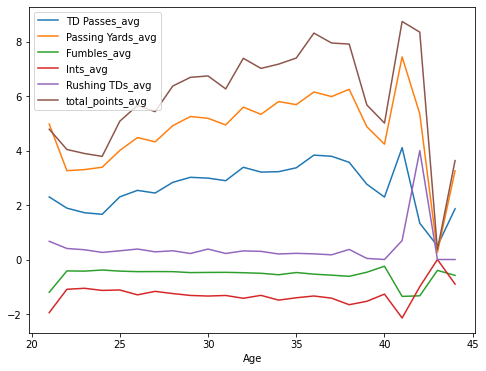

In [11]:
df_age = df_age.set_index('Age')
df_age.plot(figsize=(8, 6))

<AxesSubplot:xlabel='Birth Place'>

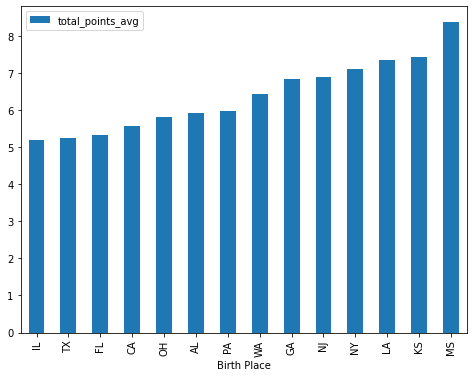

In [12]:
df_birthdayplace.plot(x="Birth Place", y=["total_points_avg"], kind="bar", figsize=(8, 6))

In [13]:
df_birthdayplace

,Birth Place,TD Passes_avg,Passing Yards_avg,Fumbles_avg,Ints_avg,Rushing TDs_avg,total_points_avg,qtd_players
4,IL,2.269058,4.119594,-0.173997,-1.249263,0.227660,5.193052,87.0
12,TX,2.407140,4.234441,-0.533216,-1.160654,0.305649,5.253360,249.0
2,FL,2.426158,4.529745,-0.738944,-1.136841,0.235029,5.315147,71.0
1,CA,2.536367,4.458073,-0.412126,-1.254648,0.234343,5.562009,449.0
10,OH,2.530686,4.561850,-0.426237,-1.079346,0.236758,5.823712,116.0
0,AL,2.814495,4.533680,-0.449041,-1.308193,0.317682,5.908624,58.0
11,PA,2.753168,4.678087,-0.423821,-1.232842,0.190351,5.964943,199.0
13,WA,2.792311,5.150145,-0.615298,-1.295712,0.410243,6.441689,98.0
3,GA,2.932750,5.268388,-0.676207,-1.151477,0.467383,6.840838,62.0
8,NJ,2.936833,5.333772,-0.459963,-1.325082,0.409731,6.895290,67.0


In [14]:
errors_predict

{'Maddox, Tommy': 4.828327206159154,
 'Tarkenton, Fran': 1.9736120773273125,
 'Warner, Kurt': 4.845661858074843,
 'Bartkowski, Steve': 4.509578006402136,
 'Batch, Charlie': 2.60349530008593,
 'Pagel, Mike': 1.2363311837792046,
 'McCoy, Colt': 3.495995103000587,
 'Jackson, Tarvaris': 4.099697698379165,
 'Brees, Drew': 1.5836227165560706,
 'Rivers, Philip': 2.173670064358175,
 'Landry, Greg': 3.807261696034645,
 'Pennington, Chad': 5.819286621941578,
 'Leftwich, Byron': 3.050599334894409,
 'Smith, Alex': 2.33462573086756,
 'Aikman, Troy': 0.19439529083048473,
 'Ferragamo, Vince': 5.937766978124206,
 'Orton, Kyle': 7.986465131323743,
 'Stafford, Matthew': 0.7430117940363393,
 'Hanratty, Terry': 4.016885962970093,
 'Daniel, Chase': 0.8775440418437541,
 'Zolak, Scott': 1.7722484068752675,
 'Dilfer, Trent': 3.679772832007128,
 'Brady, Tom': 1.6652143105802502,
 'Flutie, Doug': 14.686180274170068,
 'Fouts, Dan': 2.6355844621916726,
 'Marino, Dan': 1.045371259869398,
 'Orlovsky, Dan': 2.640397

<h4> Analisando Jogadores que a previsão foi boa e ruim </h4>

In [15]:
worth_predictions = ['Testaverde, Vinny', 'Everett, Jim', 'Orton, Kyle', 'Flutie, Doug', 'Majkowski, Don', 'Schaub, Matt']
best_predictions = ['Kosar, Bernie', 'Detmer, Koy', 'Stafford, Matthew', 'Henne, Chad']

In [16]:
## Função que calcula a pontuação para os QBs (mesma função implemantada anteriormente)
def calc_points_qb(df_in):
    df = df_in.copy()
    ## Calcula a pontuação
    dict_points_qb = {
        'TD Passes' : 4,
        'Passing Yards' : 1/25,
        'Fumbles' : -2,
        'Ints' : -2,
        'Rushing TDs' : 6
    }
    df = df.groupby(by=['Player Id', 'Year'], dropna=False).sum()
    df = df.reset_index()
    df['total_points'] = 0
    columns_use = []
    for i in dict_points_qb.keys():
        df[i] = df[i]*dict_points_qb[i]
        column_name = i+'_avg'
        columns_use.append(column_name)
        df[column_name] = df[i] / df['Games Played']
        df['total_points'] = df['total_points'] + df[i]
    columns_use.append('total_points_avg')
    df['total_points_avg'] = df['total_points'] / df['Games Played']
    return df

<h3> Jogadores que tiveram uma previsão ruim </h3>

In [17]:
df_basic[df_basic["Name"] == 'Testaverde, Vinny']

,Age,Birth Place,Birthday,College,Current Status,Current Team,Experience,Height (inches),High School,High School Location,Name,Number,Player Id,Position,Weight (lbs),Years Played
12191,53.0,"Brooklyn , NY",11/13/1963,Miami (Fla.),Retired,NaN,21 Seasons,77.0,NaN,NaN,"Testaverde, Vinny",NaN,vinnytestaverde/2503284,NaN,233.0,1987 - 2007


In [18]:
## Filtra apenas para o jogador em questão
df = df_game_stats_qb[df_game_stats_qb["Name"] == 'Testaverde, Vinny']
df = calc_points_qb(df)
df

,Player Id,Year,Week,Games Played,Games Started,Passes Completed,Passes Attempted,Completion Percentage,Passing Yards,Passing Yards Per Attempt,...,Rushing TDs,Fumbles,Fumbles Lost,total_points,TD Passes_avg,Passing Yards_avg,Fumbles_avg,Ints_avg,Rushing TDs_avg,total_points_avg
0,vinnytestaverde/2503284,1987,108,6.0,0.0,71.0,165.0,257.7,43.24,35.2,...,6.0,-0.0,0.0,57.24,3.333333,7.206667,-0.000000,-2.000000,1.000000,9.540000
1,vinnytestaverde/2503284,1988,136,15.0,0.0,222.0,466.0,726.7,129.60,104.2,...,6.0,-0.0,0.0,117.60,3.466667,8.640000,-0.000000,-4.666667,0.400000,7.840000
2,vinnytestaverde/2503284,1989,120,14.0,0.0,258.0,480.0,748.5,125.32,87.4,...,0.0,-0.0,0.0,161.32,5.714286,8.951429,-0.000000,-3.142857,0.000000,11.522857
3,vinnytestaverde/2503284,1990,131,14.0,0.0,203.0,365.0,784.7,112.72,109.0,...,6.0,-0.0,0.0,150.72,4.857143,8.051429,-0.000000,-2.571429,0.428571,10.765714
4,vinnytestaverde/2503284,1991,113,13.0,12.0,166.0,326.0,631.5,79.76,74.9,...,0.0,-10.0,0.0,71.76,2.461538,6.135385,-0.769231,-2.307692,0.000000,5.520000
5,vinnytestaverde/2503284,1992,147,14.0,14.0,206.0,358.0,802.9,102.16,98.0,...,12.0,-8.0,1.0,130.16,4.000000,7.297143,-0.571429,-2.285714,0.857143,9.297143
6,vinnytestaverde/2503284,1993,157,10.0,6.0,130.0,230.0,563.5,71.88,76.2,...,0.0,-8.0,3.0,101.88,5.600000,7.188000,-0.800000,-1.800000,0.000000,10.188000
7,vinnytestaverde/2503284,1994,184,16.0,15.0,240.0,437.0,867.8,119.48,108.0,...,12.0,-6.0,2.0,157.48,4.500000,7.467500,-0.375000,-2.500000,0.750000,9.842500
8,vinnytestaverde/2503284,1995,146,13.0,12.0,241.0,392.0,814.7,115.32,98.5,...,12.0,-8.0,1.0,167.32,5.230769,8.870769,-0.615385,-1.538462,0.923077,12.870769
9,vinnytestaverde/2503284,1996,171,17.0,16.0,331.0,563.0,980.6,169.80,131.6,...,12.0,-18.0,7.0,257.80,7.764706,9.988235,-1.058824,-2.235294,0.705882,15.164706


In [19]:
df_basic[df_basic["Name"] == 'Everett, Jim']

,Age,Birth Place,Birthday,College,Current Status,Current Team,Experience,Height (inches),High School,High School Location,Name,Number,Player Id,Position,Weight (lbs),Years Played
14755,54.0,"Emporia , KS",1/3/1963,Purdue,Retired,NaN,12 Seasons,77.0,NaN,NaN,"Everett, Jim",NaN,jimeverett/2500577,NaN,212.0,1986 - 1997


In [20]:
## Filtra apenas para o jogador em questão
df = df_game_stats_qb[df_game_stats_qb["Name"] == 'Everett, Jim']
df = calc_points_qb(df)
df

,Player Id,Year,Week,Games Played,Games Started,Passes Completed,Passes Attempted,Completion Percentage,Passing Yards,Passing Yards Per Attempt,...,Rushing TDs,Fumbles,Fumbles Lost,total_points,TD Passes_avg,Passing Yards_avg,Fumbles_avg,Ints_avg,Rushing TDs_avg,total_points_avg
0,jimeverett/2500577,1986,143,7.0,0.0,82.0,165.0,352.3,46.16,50.6,...,6.0,-0.0,0.0,68.16,5.142857,6.594286,-0.000000,-2.857143,0.857143,9.737143
1,jimeverett/2500577,1987,98,11.0,0.0,162.0,302.0,606.1,82.56,79.4,...,6.0,-0.0,0.0,102.56,3.636364,7.505455,-0.000000,-2.363636,0.545455,9.323636
2,jimeverett/2500577,1988,153,17.0,0.0,327.0,562.0,1005.8,168.44,129.6,...,0.0,-0.0,0.0,258.44,7.764706,9.908235,-0.000000,-2.470588,0.000000,15.202353
3,jimeverett/2500577,1989,190,19.0,0.0,363.0,631.0,1096.5,201.88,155.0,...,6.0,-0.0,0.0,293.88,6.947368,10.625263,-0.000000,-2.421053,0.315789,15.467368
4,jimeverett/2500577,1990,171,17.0,0.0,320.0,572.0,969.3,165.08,124.0,...,6.0,-0.0,0.0,229.08,5.411765,9.710588,-0.000000,-2.000000,0.352941,13.475294
5,jimeverett/2500577,1991,147,16.0,16.0,277.0,490.0,878.3,137.52,110.1,...,0.0,-24.0,0.0,117.52,2.750000,8.595000,-1.500000,-2.500000,0.000000,7.345000
6,jimeverett/2500577,1992,145,16.0,16.0,281.0,475.0,953.3,132.92,115.7,...,0.0,-10.0,3.0,174.92,5.500000,8.307500,-0.625000,-2.250000,0.000000,10.932500
7,jimeverett/2500577,1993,155,10.0,9.0,135.0,274.0,476.3,66.08,56.9,...,0.0,-14.0,4.0,60.08,3.200000,6.608000,-1.400000,-2.400000,0.000000,6.008000
8,jimeverett/2500577,1994,144,16.0,16.0,346.0,540.0,1022.6,154.20,116.2,...,0.0,-6.0,2.0,200.20,5.500000,9.637500,-0.375000,-2.250000,0.000000,12.512500
9,jimeverett/2500577,1995,147,16.0,16.0,345.0,567.0,962.7,158.80,113.0,...,0.0,-12.0,4.0,222.80,6.500000,9.925000,-0.750000,-1.750000,0.000000,13.925000


In [21]:
df_basic[df_basic["Name"] == 'Orton, Kyle']

,Age,Birth Place,Birthday,College,Current Status,Current Team,Experience,Height (inches),High School,High School Location,Name,Number,Player Id,Position,Weight (lbs),Years Played
4251,34.0,"Altoona , IA",11/14/1982,Purdue,Retired,NaN,10 Seasons,76.0,NaN,NaN,"Orton, Kyle",NaN,kyleorton/2506444,NaN,228.0,2005 - 2014


In [22]:
## Filtra apenas para o jogador em questão
df = df_game_stats_qb[df_game_stats_qb["Name"] == 'Orton, Kyle']
df = calc_points_qb(df)
df

,Player Id,Year,Week,Games Played,Games Started,Passes Completed,Passes Attempted,Completion Percentage,Passing Yards,Passing Yards Per Attempt,...,Rushing TDs,Fumbles,Fumbles Lost,total_points,TD Passes_avg,Passing Yards_avg,Fumbles_avg,Ints_avg,Rushing TDs_avg,total_points_avg
0,kyleorton/2506444,2005,168,15.0,15.0,190.0,368.0,758.1,74.76,73.3,...,0.0,-24.0,5.0,60.76,2.400000,4.984000,-1.600000,-1.733333,0.000000,4.050667
1,kyleorton/2506444,2006,216,3.0,0.0,20.0,36.0,156.3,7.60,12.6,...,0.0,-0.0,0.0,5.60,0.000000,2.533333,-0.000000,-0.666667,0.000000,1.866667
2,kyleorton/2506444,2007,154,7.0,3.0,74.0,131.0,339.5,31.04,37.6,...,0.0,-4.0,0.0,37.04,2.285714,4.434286,-0.571429,-0.857143,0.000000,5.291429
3,kyleorton/2506444,2008,155,19.0,18.0,298.0,508.0,1113.0,130.76,122.6,...,18.0,-16.0,5.0,186.76,4.210526,6.882105,-0.842105,-1.368421,0.947368,9.829474
4,kyleorton/2506444,2009,156,19.0,18.0,375.0,599.0,1189.4,166.76,134.2,...,0.0,-8.0,2.0,214.76,4.631579,8.776842,-0.421053,-1.684211,0.000000,11.303158
5,kyleorton/2506444,2010,154,17.0,17.0,331.0,555.0,1008.8,162.00,121.7,...,0.0,-8.0,4.0,228.00,5.647059,9.529412,-0.470588,-1.294118,0.000000,13.411765
6,kyleorton/2506444,2011,157,12.0,11.0,178.0,294.0,652.7,86.64,80.9,...,0.0,-4.0,2.0,106.64,3.666667,7.220000,-0.333333,-1.666667,0.000000,8.886667
7,kyleorton/2506444,2012,158,4.0,0.0,32.0,44.0,293.3,14.32,32.8,...,0.0,-2.0,1.0,12.32,1.000000,3.580000,-0.500000,-1.000000,0.000000,3.080000
8,kyleorton/2506444,2013,152,8.0,3.0,50.0,73.0,541.9,22.24,49.3,...,0.0,-0.0,0.0,30.24,2.000000,2.780000,-0.000000,-1.000000,0.000000,3.780000
9,kyleorton/2506444,2014,144,12.0,12.0,287.0,447.0,764.0,120.72,85.8,...,6.0,-6.0,3.0,172.72,6.000000,10.060000,-0.500000,-1.666667,0.500000,14.393333


<h3> Jogadores que tiveram boas previsões </h3>

In [23]:
df_basic[df_basic["Name"] == 'Kosar, Bernie']

,Age,Birth Place,Birthday,College,Current Status,Current Team,Experience,Height (inches),High School,High School Location,Name,Number,Player Id,Position,Weight (lbs),Years Played
15737,53.0,"Boardman , OH",11/25/1963,Miami (Fla.),Retired,NaN,12 Seasons,77.0,NaN,NaN,"Kosar, Bernie",NaN,berniekosar/2501648,NaN,214.0,1985 - 1996


In [24]:
df = df_game_stats_qb[df_game_stats_qb["Name"] == 'Kosar, Bernie']
df = calc_points_qb(df)
df

,Player Id,Year,Week,Games Played,Games Started,Passes Completed,Passes Attempted,Completion Percentage,Passing Yards,Passing Yards Per Attempt,...,Rushing TDs,Fumbles,Fumbles Lost,total_points,TD Passes_avg,Passing Yards_avg,Fumbles_avg,Ints_avg,Rushing TDs_avg,total_points_avg
0,berniekosar/2501648,1985,154,13.0,0.0,134.0,267.0,696.9,65.76,70.5,...,6.0,-0.0,0.0,91.76,2.769231,5.058462,-0.000000,-1.230769,0.461538,7.058462
1,berniekosar/2501648,1986,173,18.0,0.0,361.0,627.0,1034.6,184.08,131.5,...,0.0,-0.0,0.0,236.08,4.444444,10.226667,-0.000000,-1.555556,0.000000,13.115556
2,berniekosar/2501648,1987,143,14.0,0.0,287.0,461.0,868.8,144.72,110.8,...,6.0,-0.0,0.0,240.72,8.000000,10.337143,-0.000000,-1.571429,0.428571,17.194286
3,berniekosar/2501648,1988,93,9.0,0.0,156.0,259.0,526.0,75.60,64.8,...,6.0,-0.0,0.0,107.60,4.444444,8.400000,-0.000000,-1.555556,0.666667,11.955556
4,berniekosar/2501648,1989,162,17.0,0.0,321.0,544.0,1030.8,151.84,124.1,...,6.0,-0.0,0.0,217.84,5.411765,8.931765,-0.000000,-1.882353,0.352941,12.814118
5,berniekosar/2501648,1990,110,13.0,0.0,230.0,423.0,696.6,102.48,77.2,...,0.0,-0.0,0.0,112.48,3.076923,7.883077,-0.000000,-2.307692,0.000000,8.652308
6,berniekosar/2501648,1991,148,16.0,16.0,307.0,494.0,1006.4,139.48,113.7,...,0.0,-20.0,0.0,173.48,4.500000,8.717500,-1.250000,-1.125000,0.000000,10.842500
7,berniekosar/2501648,1992,78,7.0,7.0,103.0,155.0,463.5,46.40,50.0,...,0.0,-2.0,1.0,62.40,4.571429,6.628571,-0.285714,-2.000000,0.000000,8.914286
8,berniekosar/2501648,1993,220,13.0,7.0,120.0,210.0,599.6,52.00,69.8,...,0.0,-12.0,1.0,70.00,2.769231,4.000000,-0.923077,-0.461538,0.000000,5.384615
9,berniekosar/2501648,1994,182,2.0,0.0,7.0,12.0,58.3,3.20,6.7,...,0.0,-0.0,0.0,5.20,2.000000,1.600000,-0.000000,-1.000000,0.000000,2.600000


In [25]:
df_basic[df_basic["Name"] == 'Detmer, Koy']

,Age,Birth Place,Birthday,College,Current Status,Current Team,Experience,Height (inches),High School,High School Location,Name,Number,Player Id,Position,Weight (lbs),Years Played
14378,43.0,"San Antonio , TX",7/5/1973,Colorado,Retired,NaN,10 Seasons,73.0,NaN,NaN,"Detmer, Koy",NaN,koydetmer/2500378,NaN,195.0,1997 - 2006


In [26]:
df = df_game_stats_qb[df_game_stats_qb["Name"] == 'Detmer, Koy']
df = calc_points_qb(df)
df

,Player Id,Year,Week,Games Played,Games Started,Passes Completed,Passes Attempted,Completion Percentage,Passing Yards,Passing Yards Per Attempt,...,Rushing TDs,Fumbles,Fumbles Lost,total_points,TD Passes_avg,Passing Yards_avg,Fumbles_avg,Ints_avg,Rushing TDs_avg,total_points_avg
0,koydetmer/2500378,1998,145,8.0,5.0,97.0,181.0,346.9,40.44,37.0,...,0.0,-2.0,0.0,48.44,2.5,5.055000,-0.250000,-1.250000,0.0,6.055000
1,koydetmer/2500378,1999,137,1.0,1.0,10.0,29.0,34.5,7.24,6.2,...,0.0,-0.0,0.0,15.24,12.0,7.240000,-0.000000,-4.000000,0.0,15.240000
2,koydetmer/2500378,2000,174,18.0,0.0,0.0,1.0,0.0,0.00,0.0,...,0.0,-0.0,0.0,-2.00,0.0,0.000000,-0.000000,-0.111111,0.0,-0.111111
3,koydetmer/2500378,2001,205,18.0,0.0,5.0,14.0,35.7,2.04,3.6,...,0.0,-0.0,0.0,0.04,0.0,0.113333,-0.000000,-0.111111,0.0,0.002222
4,koydetmer/2500378,2002,196,20.0,2.0,32.0,51.0,277.7,13.76,20.8,...,6.0,-4.0,0.0,21.76,0.4,0.688000,-0.200000,-0.100000,0.3,1.088000
5,koydetmer/2500378,2003,189,18.0,0.0,10.0,19.0,200.0,4.80,22.3,...,0.0,-0.0,0.0,2.80,0.0,0.266667,-0.000000,-0.111111,0.0,0.155556
6,koydetmer/2500378,2004,208,19.0,1.0,19.0,41.0,171.5,8.40,10.3,...,0.0,-2.0,1.0,2.40,0.0,0.442105,-0.105263,-0.210526,0.0,0.126316
7,koydetmer/2500378,2005,147,16.0,0.0,32.0,56.0,332.0,9.52,25.6,...,0.0,-4.0,2.0,-0.48,0.0,0.595000,-0.250000,-0.375000,0.0,-0.030000
8,koydetmer/2500378,2006,43,6.0,0.0,11.0,24.0,133.3,2.60,8.1,...,0.0,-2.0,1.0,-1.40,0.0,0.433333,-0.333333,-0.333333,0.0,-0.233333


In [27]:
df_basic[df_basic["Name"] == 'Stafford, Matthew']

,Age,Birth Place,Birthday,College,Current Status,Current Team,Experience,Height (inches),High School,High School Location,Name,Number,Player Id,Position,Weight (lbs),Years Played
4418,29.0,"Tampa , FL",2/7/1988,Georgia,Active,Detroit Lions,9th season,75.0,Highland Park HS,"Dallas, TX","Stafford, Matthew",9.0,matthewstafford/79860,QB,226.0,NaN


In [28]:
df = df_game_stats_qb[df_game_stats_qb["Name"] == 'Stafford, Matthew']
df = calc_points_qb(df)
df

,Player Id,Year,Week,Games Played,Games Started,Passes Completed,Passes Attempted,Completion Percentage,Passing Yards,Passing Yards Per Attempt,...,Rushing TDs,Fumbles,Fumbles Lost,total_points,TD Passes_avg,Passing Yards_avg,Fumbles_avg,Ints_avg,Rushing TDs_avg,total_points_avg
0,matthewstafford/79860,2009,123,14.0,12.0,231.0,432.0,741.7,106.24,88.2,...,12.0,-12.0,2.0,114.24,4.000000,7.588571,-0.857143,-3.428571,0.857143,8.160000
1,matthewstafford/79860,2010,123,7.0,7.0,94.0,148.0,458.1,35.52,41.4,...,6.0,-6.0,1.0,65.52,5.142857,5.074286,-0.857143,-0.857143,0.857143,9.360000
2,matthewstafford/79860,2011,172,21.0,21.0,474.0,739.0,1380.8,232.52,185.0,...,6.0,-10.0,1.0,388.52,9.333333,11.072381,-0.476190,-1.714286,0.285714,18.500952
3,matthewstafford/79860,2012,158,20.0,20.0,461.0,764.0,1234.8,213.08,153.6,...,24.0,-12.0,4.0,281.08,4.600000,10.654000,-0.600000,-1.800000,1.200000,14.054000
4,matthewstafford/79860,2013,154,20.0,20.0,398.0,689.0,1103.5,198.40,137.1,...,12.0,-24.0,4.0,266.40,6.000000,9.920000,-1.200000,-2.000000,0.600000,13.320000
5,matthewstafford/79860,2014,193,21.0,20.0,427.0,699.0,1303.5,204.00,153.5,...,12.0,-26.0,6.0,268.00,5.142857,9.714286,-1.238095,-1.428571,0.571429,12.761905
6,matthewstafford/79860,2015,154,19.0,19.0,417.0,617.0,1332.9,182.80,167.7,...,6.0,-10.0,2.0,292.80,7.368421,9.621053,-0.526316,-1.368421,0.315789,15.410526
7,matthewstafford/79860,2016,171,20.0,20.0,432.0,666.0,1308.4,191.92,148.0,...,12.0,-10.0,3.0,267.92,4.800000,9.596000,-0.500000,-1.100000,0.600000,13.396000
